ML PROJECT ON MALARIA DETECTION

Vivek Jain : 2021218
Manan Garg : 2021163
Tushar : 2020478

DATASET LINK: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [21]:
from save_load import save_model, load_model, save_feature, load_feature
from utils import import_images, make_label
from LocalFeature import LocalFeature
import numpy as np
import pandas as pd
import cv2
import preprocessing
from general_models import LogisticModel, SVMModel, DTModel, ada_boost, naive_bayes, k_nearest_neighbors, random_forest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import copy

In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt
def metric(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    return matrix,accuracy,precision,recall,f1

def plot_roc(y1, y2, prob_list,classes):
    fpr = []
    tpr = []
    roc_auc = []
    for i,name in enumerate(classes):
        if name == 'SIFT BOVW':
            f, t, _ = metrics.roc_curve(y2, prob_list[i], pos_label=1)
            ra = metrics.roc_auc_score(y2, prob_list[i])
            fpr.append(f)
            tpr.append(t)
            roc_auc.append(ra)
            continue
        f, t, _ = metrics.roc_curve(y1, prob_list[i], pos_label=1)
        ra = metrics.roc_auc_score(y1, prob_list[i])
        fpr.append(f)
        tpr.append(t)
        roc_auc.append(ra)

    plt.figure(figsize=(12, 6))
    colors = [ 'red','orange', 'purple']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i],label='ROC curve for ' + classes[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

<h3>Import images in original and grayscale

In [23]:
p_img, p_grey = import_images(r'D:\Downloads\MalariaDetection-main-20230525T122924Z-001\MalariaDetection-main\dataset\test\cell_images\Parasitized\*.png')
u_img, u_grey = import_images(r'D:\Downloads\MalariaDetection-main-20230525T122924Z-001\MalariaDetection-main\dataset\test\cell_images\Uninfected\*.png')

In [24]:
original_image = p_img.copy()
original_image.extend(u_img)
gray_image = p_grey.copy()
gray_image.extend(u_grey)

In [25]:
save_feature(original_image,'./features_pkl/original_images')
save_feature(gray_image,'./features_pkl/original_images_gray')

Successfully saved features
Successfully saved features


In [26]:
original_image = load_feature('./features_pkl/original_images.pkl')
gray_image = load_feature('./features_pkl/original_images_gray.pkl')
print("Original shape:",len(original_image))
print("Gray shape:",len(gray_image))

Original shape: 27558
Gray shape: 27558


In [27]:
label = make_label(27558)
label.shape

(27558,)

<h3>Resize Gray image

In [28]:
np_img = preprocessing.resize_image(original_image, 27558, 64)
save_feature(np_img,'./features_pkl/raw_resized_features')

Successfully saved features


In [29]:
np_img = load_feature('./features_pkl/raw_resized_features.pkl')
print(np_img.shape)

(27558, 64, 64, 3)


<h3> Global feature extraction on raw images

In [30]:
np_original = preprocessing.global_feature_extractor(gray_image, 27558)
save_feature(np_original,'./features_pkl/global_raw_image_features')

Successfully saved features


In [31]:
np_original = load_feature('./features_pkl/global_raw_image_features.pkl')
print(np_original.shape)

(27558, 28)


<h3>Global feature extraction on canny filter

In [32]:
%%time
canny_images = preprocessing.canny_preprocessing(gray_image, 27558)
np_canny = preprocessing.global_feature_extractor(canny_images, 27558)
save_feature(np_canny,'./features_pkl/global_canny_image_features')

Successfully saved features
CPU times: total: 1min 42s
Wall time: 10min 46s


In [33]:
np_canny = load_feature('./features_pkl/global_canny_image_features.pkl')
print(np_canny.shape)

(27558, 28)


<h3>Global feature extraction on clahe filter

In [34]:
%%time
clahe_images = preprocessing.clahe_preprocessing(gray_image, 27558)
np_clahe = preprocessing.global_feature_extractor(clahe_images, 27558)
save_feature(np_clahe,'./features_pkl/global_clahe_image_features')

Successfully saved features
CPU times: total: 1min 35s
Wall time: 10min 5s


In [35]:
np_clahe = load_feature('./features_pkl/global_clahe_image_features.pkl')
print(np_clahe.shape)

(27558, 28)


<h3>Global feature extraction on sobel edge detection

In [36]:
%%time
sobel_images = preprocessing.sobel_preprocessing(gray_image, 27558)
np_sobel = preprocessing.global_feature_extractor(sobel_images, 27558)
save_feature(np_sobel,'./features_pkl/global_sobel_image_features')

Successfully saved features
CPU times: total: 1min 46s
Wall time: 11min 26s


In [37]:
np_sobel = load_feature('./features_pkl/global_sobel_image_features.pkl')
print(np_sobel.shape)

(27558, 28)


<h3>Global feature extraction on scharr edge detection

In [38]:
%%time
scharr_images = preprocessing.scharr_preprocessing(gray_image, 27558)
np_scharr = preprocessing.global_feature_extractor(scharr_images, 27558)
save_feature(np_scharr,'./features_pkl/global_scharr_image_features')

Successfully saved features
CPU times: total: 2min 31s
Wall time: 12min 23s


In [39]:
np_scharr = load_feature('./features_pkl/global_scharr_image_features.pkl')
print(np_scharr.shape)

(27558, 28)


<h3>Global feature test accuracy on baseline model

In [40]:
from sklearn.preprocessing import StandardScaler

def StandardScaling_1(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    return X

In [41]:
ll = ['raw', 'canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
dt_acc = []
rf_acc = []
knn_acc = []
nb_acc = []
ab_acc = []
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling_1(x_train)
    x_test = StandardScaling_1(x_test)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    dt_acc.append(DTModel(x_train, x_test, y_train, y_test))
    rf_acc.append(random_forest(x_train, x_test, y_train, y_test))
    knn_acc.append(k_nearest_neighbors(x_train, x_test, y_train, y_test))
    nb_acc.append(naive_bayes(x_train, x_test, y_train, y_test))
    ab_acc.append(ada_boost(x_train, x_test, y_train, y_test))
    print("Training Done for :", itr)

Training Done for : raw
Training Done for : canny
Training Done for : clahe
Training Done for : scharr
Training Done for : sobel


In [42]:
df = pd.DataFrame({'Model' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc, "DT Accuracy": dt_acc, "RF Accuracy": rf_acc, "KNN Accuracy": knn_acc, "NB Accuracy": nb_acc, "AB Accuracy": ab_acc})
df

,Model,Logistic Accuracy,SVM Accuracy,DT Accuracy,RF Accuracy,KNN Accuracy,NB Accuracy,AB Accuracy
0,raw,0.863570,0.872424,0.693759,0.800726,0.739478,0.494194,0.771553
1,canny,0.839042,0.862700,0.776633,0.858926,0.829608,0.731205,0.836865
2,clahe,0.826560,0.852395,0.589840,0.749927,0.797388,0.671988,0.801306
3,scharr,0.894340,0.893759,0.784615,0.875907,0.851379,0.761684,0.859071
4,sobel,0.912627,0.909144,0.791727,0.883599,0.852685,0.784470,0.862264


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ll = ['raw', 'canny', 'clahe', 'scharr', 'sobel']
log_ac = []
log_pr = []
log_re = []
log_f1 = []
svc_ac = []
svc_pr = []
svc_re = []
svc_f1 = []
dt_ac = []
dt_pr = []
dt_re = []
dt_f1 = []
rf_ac, rf_pr, rf_re, rf_f1 = [],[],[],[]
knn_ac, knn_pr, knn_re, knn_f1 = [],[],[],[]
ab_ac, ab_pr, ab_re, ab_f1 = [],[],[],[]
nb_ac, nb_pr, nb_re, nb_f1 = [],[],[],[]
for itr in ll:
    print(itr)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling_1(x_train)
    x_test = StandardScaling_1(x_test)
    # log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    # svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    # dt_acc.append(DTModel(x_train, x_test, y_train, y_test))
    model = LogisticRegression(max_iter = 500)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    # print("logistic Regression : ",b,c,d,e)
    log_ac.append(b)
    log_pr.append(c)
    log_re.append(d)
    log_f1.append(e)
    

    clf_svc = SVC().fit(x_train, y_train)
    y_pred = clf_svc.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    # print("SVM : ",b,c,d,e)'
    svc_ac.append(b)
    svc_pr.append(c)
    svc_re.append(d)
    svc_f1.append(e)

    dt_model = DecisionTreeClassifier()
    dt_model.fit(x_train, y_train)
    y_pred = dt_model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    # print("DT : ",b,c,d,e)
    dt_ac.append(b)
    dt_pr.append(c)
    dt_re.append(d)
    dt_f1.append(e)

    rf_model = RandomForestClassifier()
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    rf_ac.append(b)
    rf_pr.append(c)
    rf_re.append(d)
    rf_f1.append(e)

    knn_model = KNeighborsClassifier()
    knn_model.fit(x_train, y_train)
    y_pred = knn_model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    knn_ac.append(b)
    knn_pr.append(c)
    knn_re.append(d)
    knn_f1.append(e)

    nb_model = GaussianNB()
    nb_model.fit(x_train, y_train)
    y_pred = nb_model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    nb_ac.append(b)
    nb_pr.append(c)
    nb_re.append(d)
    nb_f1.append(e)

    ab_model = AdaBoostClassifier()
    ab_model.fit(x_train, y_train)
    y_pred = ab_model.predict(x_test)
    a,b,c,d,e = metric(y_test, y_pred)
    ab_ac.append(b)
    ab_pr.append(c)
    ab_re.append(d)
    ab_f1.append(e)

    print("Training Done for :", itr)

raw


Training Done for : raw
canny
Training Done for : canny
clahe
Training Done for : clahe
scharr
Training Done for : scharr
sobel
Training Done for : sobel


In [44]:
df = pd.DataFrame({'Model' : ll , "Logistic Accuracy" : log_ac, "Logistic Precision": log_pr, "Logistic Recall": log_re, "Logistic f1": log_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "SVM Accuracy" : svc_ac, "SVM Precision": svc_pr, "SVM Recall": svc_re, "SVM f1": svc_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "DT Accuracy" : dt_ac, "DT Precision": dt_pr, "DT Recall": dt_re, "DT f1": dt_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "RF Accuracy" : rf_ac, "RF Precision": rf_pr, "RF Recall": rf_re, "RF f1": rf_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "KNN Accuracy" : knn_ac, "KNN Precision": knn_pr, "KNN Recall": knn_re, "KNN f1": knn_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "NB Accuracy" : nb_ac, "NB Precision": nb_pr, "NB Recall": nb_re, "NB f1": nb_f1})
print(df)
print()
df = pd.DataFrame({'Model' : ll , "AB Accuracy" : dt_ac, "AB Precision": dt_pr, "AB Recall": dt_re, "AB f1": dt_f1})
print(df)
print()

    Model  Logistic Accuracy  Logistic Precision  Logistic Recall  Logistic f1
0     raw           0.863570            0.877600         0.848363     0.862734
1   canny           0.839042            0.823915         0.866743     0.844787
2   clahe           0.826560            0.847674         0.800689     0.823512
3  scharr           0.894340            0.910310         0.877369     0.893536
4   sobel           0.912627            0.928571         0.896037     0.912014

    Model  SVM Accuracy  SVM Precision  SVM Recall    SVM f1
0     raw      0.872424       0.881113    0.864159  0.872553
1   canny      0.862700       0.862286    0.866743  0.864509
2   clahe      0.852395       0.855085    0.852384  0.853732
3  scharr      0.893759       0.907528    0.879380  0.893232
4   sobel      0.909144       0.931942    0.884836  0.907778

    Model  DT Accuracy  DT Precision  DT Recall     DT f1
0     raw     0.726415      0.705640   0.786904  0.744060
1   canny     0.775327      0.787285   0.7

<h3>SIFT and KAZE

In [45]:
%%time
ll = ['SIFT', 'KAZE']
log_acc = []
svc_acc = []
dt_acc = []
rf_acc = []
knn_acc = []
nb_acc = []
ab_acc = []
for itr in ll:
    LF = LocalFeature(feature_type = itr, cluster_size = 50, test_size = 0.25, image_type = 'original')
    x_train, x_test, y_train, y_test = LF.fit(np_img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    dt_acc.append(DTModel(x_train, x_test, y_train, y_test))
    rf_acc.append(random_forest(x_train, x_test, y_train, y_test))
    knn_acc.append(k_nearest_neighbors(x_train, x_test, y_train, y_test))
    nb_acc.append(naive_bayes(x_train, x_test, y_train, y_test))
    ab_acc.append(ada_boost(x_train, x_test, y_train, y_test))
    print("Training Done")

    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc, "DT Accuracy": dt_acc, "RF Accuracy": rf_acc, "KNN Accuracy": knn_acc, "NB Accuracy": nb_acc, "AB Accuracy": ab_acc})
df

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Done
27556 27556


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training Done
CPU times: total: 13min 17s
Wall time: 11min 4s


,Feature Type,Logistic Accuracy,SVM Accuracy,DT Accuracy,RF Accuracy,KNN Accuracy,NB Accuracy,AB Accuracy
0,SIFT,0.894427,0.902661,0.853698,0.906190,0.777680,0.879282,0.886193
1,KAZE,0.668021,0.693134,0.667296,0.669618,0.621861,0.639135,0.693279


In [46]:
%%time
ll = ['canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
dt_acc = []
rf_acc = []
knn_acc = []
nb_acc = []
ab_acc = []
for idx, itr in enumerate(ll):
    LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'filtered')
    if itr == 'canny':
        data = preprocessing.canny_preprocessing(gray_image, 27558)
    elif itr == 'clahe':
        data = preprocessing.clahe_preprocessing(gray_image, 27558)
    elif itr == 'scharr':
        data = preprocessing.scharr_preprocessing(gray_image, 27558)
    elif itr == 'sobel':
        data = preprocessing.sobel_preprocessing(gray_image, 27558)
    img = preprocessing.resize_image(data, 27558, 64)
    x_train, x_test, y_train, y_test = LF.fit(img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    dt_acc.append(DTModel(x_train, x_test, y_train, y_test))
    rf_acc.append(random_forest(x_train, x_test, y_train, y_test))
    knn_acc.append(k_nearest_neighbors(x_train, x_test, y_train, y_test))
    nb_acc.append(naive_bayes(x_train, x_test, y_train, y_test))
    ab_acc.append(ada_boost(x_train, x_test, y_train, y_test))
    # print("For Preprocessing :", ll)
    # print("Logistic Accuracy :", log_acc[idx])
    # print("SVM Accuracy", svc_acc[idx])
    
    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc, "DT Accuracy": dt_acc, "RF Accuracy": rf_acc, "KNN Accuracy": knn_acc, "NB Accuracy": nb_acc, "AB Accuracy": ab_acc})
df

18155 18155


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


27543 27543


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


17909 17909


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


19029 19029


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 22min 12s
Wall time: 17min 11s


,Feature Type,Logistic Accuracy,SVM Accuracy,DT Accuracy,RF Accuracy,KNN Accuracy,NB Accuracy,AB Accuracy
0,canny,0.820004,0.816700,0.756114,0.808108,0.755232,0.723948,0.817361
1,clahe,0.868574,0.880918,0.810340,0.878885,0.787104,0.843596,0.860587
2,scharr,0.811300,0.816659,0.748548,0.807057,0.754801,0.736266,0.809736
3,sobel,0.798235,0.805170,0.768600,0.801177,0.763136,0.746112,0.800546


In [47]:
%%time
ll = ['canny', 'clahe', 'scharr', 'sobel']
log_acc = []
svc_acc = []
dt_acc = []
rf_acc = []
knn_acc = []
nb_acc = []
ab_acc = []
for idx, itr in enumerate(ll):
    LF = LocalFeature(feature_type = 'KAZE', cluster_size = 20, test_size = 0.25, image_type = 'filtered')
    if itr == 'canny':
        data = preprocessing.canny_preprocessing(gray_image, 27558)
    elif itr == 'clahe':
        data = preprocessing.clahe_preprocessing(gray_image, 27558)
    elif itr == 'scharr':
        data = preprocessing.scharr_preprocessing(gray_image, 27558)
    elif itr == 'sobel':
        data = preprocessing.sobel_preprocessing(gray_image, 27558)
    img = preprocessing.resize_image(data, 27558, 64)
    x_train, x_test, y_train, y_test = LF.fit(img)
    log_acc.append(LogisticModel(x_train, x_test, y_train, y_test))
    svc_acc.append(SVMModel(x_train, x_test, y_train, y_test))
    dt_acc.append(DTModel(x_train, x_test, y_train, y_test))
    rf_acc.append(random_forest(x_train, x_test, y_train, y_test))
    knn_acc.append(k_nearest_neighbors(x_train, x_test, y_train, y_test))
    nb_acc.append(naive_bayes(x_train, x_test, y_train, y_test))
    ab_acc.append(ada_boost(x_train, x_test, y_train, y_test))
    # print("For Preprocessing :", ll)
    # print("Logistic Accuracy :", log_acc[idx])
    # print("SVM Accuracy", svc_acc[idx])
    
    
df = pd.DataFrame({'Feature Type' : ll , "Logistic Accuracy" : log_acc, "SVM Accuracy": svc_acc, "DT Accuracy": dt_acc, "RF Accuracy": rf_acc, "KNN Accuracy": knn_acc, "NB Accuracy": nb_acc, "AB Accuracy": ab_acc})
df

21234 21234


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


27558 27558


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


26555 26555


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


26630 26630


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 21min 28s
Wall time: 20min 54s


,Feature Type,Logistic Accuracy,SVM Accuracy,DT Accuracy,RF Accuracy,KNN Accuracy,NB Accuracy,AB Accuracy
0,canny,0.746092,0.749294,0.742324,0.745150,0.722547,0.551705,0.749670
1,clahe,0.784180,0.796662,0.792598,0.794630,0.764731,0.761103,0.785486
2,scharr,0.690465,0.696641,0.690164,0.691219,0.644675,0.668173,0.690465
3,sobel,0.685792,0.691349,0.686993,0.688795,0.635626,0.660108,0.686092


<h1>Grid Search CV

In [48]:
grid_search_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'canny', 'clahe', 'scharr', 'sobel'])

In [50]:
from general_models import StandardScaling
parameters = {'kernel':('poly', 'rbf'), 'C': np.logspace(-2, 1, num = 10)}
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
ll = ['canny', 'clahe', 'scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    svc = SVC(probability = True)
    clf = GridSearchCV(svc, parameters, refit = True, cv = 5, verbose = 3)
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_grid_search.pkl'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.790 total time= 1.3min
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.780 total time= 1.3min
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.789 total time= 1.3min
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.787 total time= 1.4min
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.796 total time= 1.6min
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.796 total time= 1.4min
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.799 total time= 1.3min
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.800 total time= 1.2min
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.796 total time= 1.1min
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.805 total time= 1.4min
[CV 1/5] END C=0.021544346900318832, kernel=poly;, score=0.786 total time=  58.9s
[CV 2/5] END C=0.021544346900318832, kernel=po

In [51]:
print(clf.best_params_)

{'C': 10.0, 'kernel': 'rbf'}


In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

ll = ['raw', 'canny', 'clahe', 'scharr', 'sobel']
svm_acc = []

for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling_1(x_train)
    x_test = StandardScaling_1(x_test)
    svmm = SVC(kernel='rbf', C=10)
    svmm.fit(x_train, y_train)
    y_pred = clf_svc.predict(x_test)
    svm_acc.append(accuracy_score(y_test, y_pred))
    print("Training Done for :", itr)

df = pd.DataFrame({'Feature Type' : ll , "SVM Accuracy": svm_acc})
df

Training Done for : raw
Training Done for : canny
Training Done for : clahe
Training Done for : scharr
Training Done for : sobel


,Feature Type,SVM Accuracy
0,raw,0.461538
1,canny,0.724819
2,clahe,0.387808
3,scharr,0.884761
4,sobel,0.909144


In [56]:
#Grid Search on SIFT
parameters = {'kernel':('poly', 'rbf'), 'C': np.logspace(-2, 1, num = 10)}
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
svc = SVC(probability = True)
clf = GridSearchCV(svc, parameters, refit = True, cv = 5, verbose = 3)
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_grid_search'
save_feature(clf, save_filename)


27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............C=0.01, kernel=poly;, score=0.612 total time= 2.2min
[CV 2/5] END ...............C=0.01, kernel=poly;, score=0.624 total time= 2.3min
[CV 3/5] END ...............C=0.01, kernel=poly;, score=0.616 total time= 2.1min
[CV 4/5] END ...............C=0.01, kernel=poly;, score=0.613 total time= 2.1min
[CV 5/5] END ...............C=0.01, kernel=poly;, score=0.613 total time= 2.0min
[CV 1/5] END ................C=0.01, kernel=rbf;, score=0.864 total time= 1.6min
[CV 2/5] END ................C=0.01, kernel=rbf;, score=0.860 total time= 1.7min
[CV 3/5] END ................C=0.01, kernel=rbf;, score=0.863 total time= 1.6min
[CV 4/5] END ................C=0.01, kernel=rbf;, score=0.863 total time= 1.7min
[CV 5/5] END ................C=0.01, kernel=rbf;, score=0.854 total time= 1.7min
[CV 1/5] END C=0.021544346900318832, kernel=poly;, score=0.665 total time= 1.9min
[CV 2/5] END C=0.021544346900318832, kernel=po

<h3>Grid Search Cv model on test data

In [57]:
prob_grid = []

In [58]:
ll = ['canny', 'clahe','scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_grid_search.pkl.pkl'
    clf = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_test = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    prob_grid.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
    print("Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    grid_search_df.loc[itr] = [accuracy,precision,recall,f1]

Accuracy-0.8690856313497823 Precision-0.8654390934844193 Recall-0.8773693279724296 F1-0.8713633770678837
Accuracy-0.8645863570391872 Precision-0.8640388460439874 Recall-0.8687535898908674 F1-0.866389803809251
Accuracy-0.9063860667634253 Precision-0.9233064756789018 Recall-0.8885697874784606 F1-0.9056051514708034
Accuracy-0.9191582002902757 Precision-0.9380053908355795 Recall-0.8994830557151062 F1-0.9183404192933587


In [59]:
y1 = copy.deepcopy(y_test)

In [60]:
#Prediction on SIFT Grid Search
filename = './features_pkl/local_'+ 'raw' + '_image_features_grid_search.pkl'
clf = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)
y_pred_test = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
prob_grid.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
print("Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
grid_search_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy-0.9017791501249817 Precision-0.8984238178633975 Recall-0.9058269570335491 F1-0.9021101992966001


In [61]:
y2 = copy.deepcopy(y_test)

In [62]:
grid_search_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.901779,0.898424,0.905827,0.90211
canny,0.869086,0.865439,0.877369,0.871363
clahe,0.864586,0.864039,0.868754,0.86639
scharr,0.906386,0.923306,0.88857,0.905605
sobel,0.919158,0.938005,0.899483,0.91834


<h3> ROC Curve for Grid Search on all 3 preprocessing techniques

In [106]:
print(len(y1))
print(len(y2))
print(len(prob_grid[0]))
for i in range (0,5):
    y1 = y1[:len(y2)]
print(len(y1))
print(len(y2))
print(len(prob_grid[0]))

6890
6801
6801
6801
6801
6801


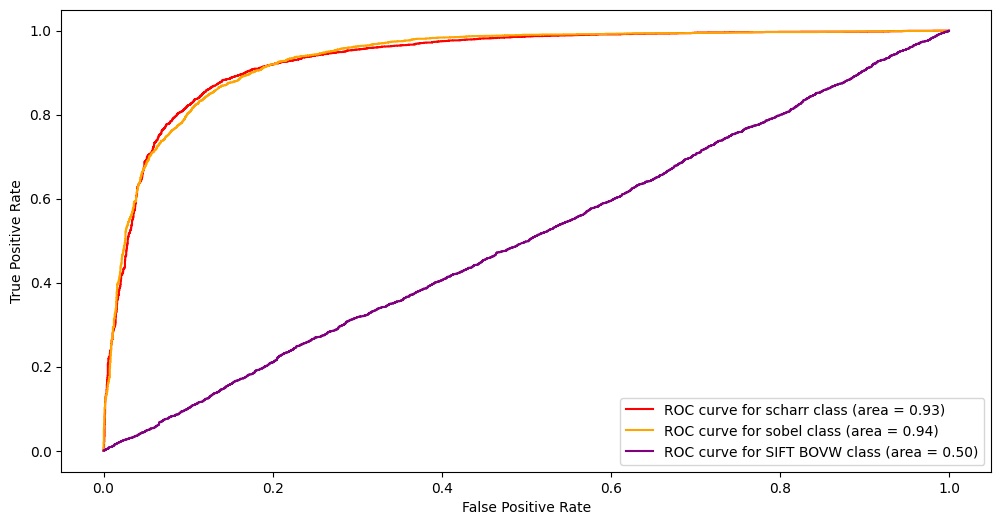

In [85]:
plot_roc(y1, y2, prob_grid, ['scharr','sobel', 'SIFT BOVW'])                                     

<h1>Ensembling: Random Tree Classifier

In [86]:
random_tree_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

In [87]:
from sklearn.ensemble import RandomForestClassifier
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = RandomForestClassifier()
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_random_tree'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Successfully saved features
Training Done for : scharr
Successfully saved features
Training Done for : sobel


In [88]:
#Random Tree on SIFT
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
clf = RandomForestClassifier()
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_random_tree'
save_feature(clf, save_filename)

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Successfully saved features


<h3>Random Tree Predictions

In [89]:
proba_random_tree = []

In [90]:
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_random_tree.pkl'
    clf = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_test = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    proba_random_tree.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
    print("Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    random_tree_df.loc[itr] = [accuracy,precision,recall,f1]

Accuracy-0.87677793904209 Precision-0.8812626701419056 Recall-0.8739230327398048 F1-0.877577505407354
Accuracy-0.8850507982583454 Precision-0.8907611853573504 Recall-0.8805284319356692 F1-0.8856152512998267


In [91]:
y1 = copy.deepcopy(y_test)

In [92]:
#Prediction on SIFT Random Tree
filename = './features_pkl/local_'+ 'raw' + '_image_features_random_tree.pkl'
clf = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)
y_pred_test = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
proba_random_tree.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_test)
print("Random Tree : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
random_tree_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Random Tree : Accuracy-0.9039847081311572 Precision-0.8988666085440279 Recall-0.9102413184226015 F1-0.9045182044158503


In [93]:
y2 = copy.deepcopy(y_test)

In [94]:
random_tree_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.903985,0.898867,0.910241,0.904518
scharr,0.876778,0.881263,0.873923,0.877578
sobel,0.885051,0.890761,0.880528,0.885615


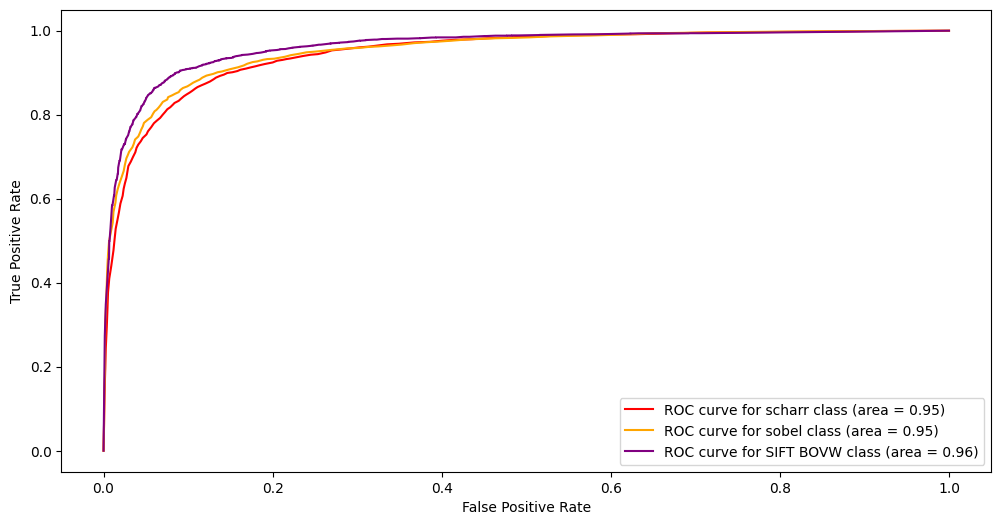

In [95]:
plot_roc(y1, y2, proba_random_tree, ['scharr', 'sobel', 'SIFT BOVW'])

<h1>Ensembling: Ada Boost

In [96]:
adaboost_dt_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

adaboost_lr_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall','F1'], 
                   index = ['SIFT BOVW', 'scharr', 'sobel'])

In [97]:
from sklearn.ensemble import AdaBoostClassifier
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = AdaBoostClassifier(algorithm = 'SAMME')
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_adaboost_default'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)
    
lr = LogisticRegression()
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_train = StandardScaling(x_train,x_train)
    clf = AdaBoostClassifier(base_estimator = lr, algorithm = 'SAMME')
    clf.fit(x_train, y_train)
    save_filename = './features_pkl/global_'+ itr + '_image_features_adaboost_lr'
    save_feature(clf, save_filename)
    print("Training Done for :", itr)

Successfully saved features
Training Done for : scharr
Successfully saved features
Training Done for : sobel


d:\Vivek\Python\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Successfully saved features
Training Done for : scharr


d:\Vivek\Python\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Successfully saved features
Training Done for : sobel


In [98]:
from sklearn.ensemble import AdaBoostClassifier
#Adaboost on SIFT
LF = LocalFeature(feature_type = 'SIFT', cluster_size = 50, test_size = 0.25, image_type = 'original')
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_train = StandardScaling(x_train, x_train)
x_test = StandardScaling(x_train,x_test)
clf = AdaBoostClassifier(algorithm = 'SAMME')
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_default'
save_feature(clf, save_filename)

#SIFT on LR
lr = LogisticRegression()
clf = AdaBoostClassifier(base_estimator = lr, algorithm = 'SAMME')
clf.fit(x_train, y_train)    
save_filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_lr'
save_feature(clf, save_filename)

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Successfully saved features


d:\Vivek\Python\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Successfully saved features


<h3>Prediction on both adaboost estimators

In [99]:
prob_dt = []
prob_lr = []

In [100]:
ll = ['scharr', 'sobel']
for itr in ll:
    filename = './features_pkl/global_'+ itr + '_image_features_adaboost_default.pkl'
    clf_deafult = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features_adaboost_lr.pkl'
    clf_lr = load_feature(filename)
    filename = './features_pkl/global_'+ itr + '_image_features.pkl'
    data = load_feature(filename)
    x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=42)
    x_test = StandardScaling(x_train,x_test)
    y_pred_default = clf_deafult.predict(x_test)
    y_pred_lr = clf_lr.predict(x_test)
    y_pred_proba = clf_deafult.predict_proba(x_test)
    prob_dt.append(y_pred_proba[:,1])
    y_pred_proba = clf_lr.predict_proba(x_test)
    prob_lr.append(y_pred_proba[:,1])
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_default)
    print("AdaBoost default : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    adaboost_dt_df.loc[itr] = [accuracy,precision,recall,f1]
    
    matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_lr)
    print("AdaBoost LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
    adaboost_lr_df.loc[itr] = [accuracy,precision,recall,f1]

AdaBoost default : Accuracy-0.8523947750362845 Precision-0.8488536654401359 Recall-0.8612866168868466 F1-0.8550249465431219
AdaBoost LR : Accuracy-0.853265602322206 Precision-0.8559492941515413 Recall-0.8532452613440551 F1-0.8545951387890119
AdaBoost default : Accuracy-0.8528301886792453 Precision-0.8423973362930077 Recall-0.8719126938541069 F1-0.8569009314140559
AdaBoost LR : Accuracy-0.8403483309143687 Precision-0.8540428061831153 Recall-0.8251005169442849 F1-0.8393222319602688


In [101]:
#Prediction on SIFT Adaboost
filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_default.pkl'
clf_deafult = load_feature(filename)
filename = './features_pkl/local_'+ 'raw' + '_image_features_adaboost_lr.pkl'
clf_lr = load_feature(filename)
x_train, x_test, y_train, y_test = LF.fit(np_img)
x_test = StandardScaling(x_train,x_test)

y_pred_default = clf_deafult.predict(x_test)
y_pred_lr = clf_lr.predict(x_test)
y_pred_proba = clf_deafult.predict_proba(x_test)
prob_dt.append(y_pred_proba[:,1])
y_pred_proba = clf_lr.predict_proba(x_test)
prob_lr.append(y_pred_proba[:,1])
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_default)
print("AdaBoost default : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
adaboost_dt_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]
    
matrix,accuracy,precision,recall,f1 = metric(y_test,y_pred_lr)
print("AdaBoost LR : Accuracy-{0} Precision-{1} Recall-{2} F1-{3}".format(accuracy,precision,recall,f1))
adaboost_lr_df.loc['SIFT BOVW'] = [accuracy,precision,recall,f1]

27204 27204


d:\Vivek\Python\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AdaBoost default : Accuracy-0.8756065284516983 Precision-0.9225165562913907 Recall-0.8198940553266627 F1-0.8681832346525397
AdaBoost LR : Accuracy-0.8781061608586973 Precision-0.919908466819222 Recall-0.8281341965862272 F1-0.8716122038098189


In [102]:
adaboost_dt_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.875607,0.922517,0.819894,0.868183
scharr,0.852395,0.848854,0.861287,0.855025
sobel,0.85283,0.842397,0.871913,0.856901


In [103]:
adaboost_lr_df

,Accuracy,Precision,Recall,F1
SIFT BOVW,0.878106,0.919908,0.828134,0.871612
scharr,0.853266,0.855949,0.853245,0.854595
sobel,0.840348,0.854043,0.825101,0.839322


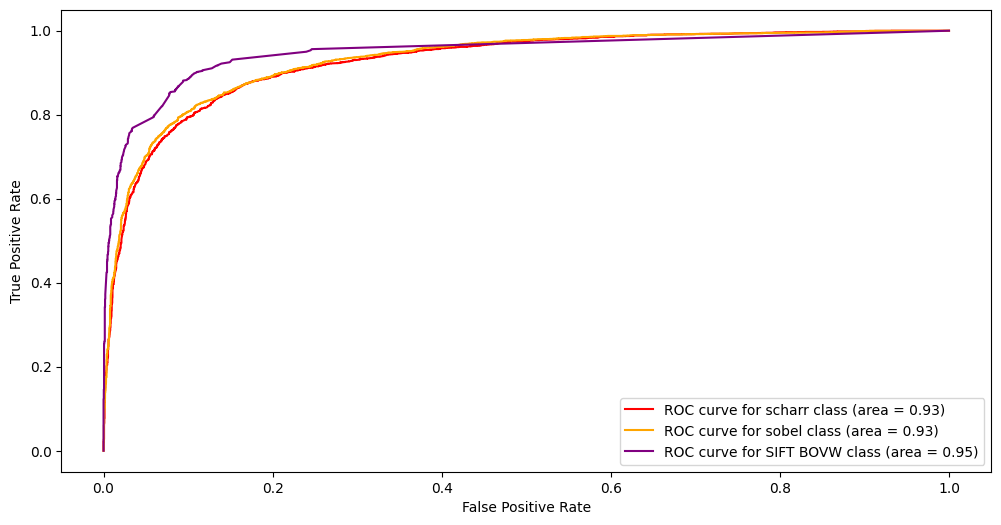

In [104]:
plot_roc(y1, y2, prob_dt, ['scharr', 'sobel', 'SIFT BOVW'])

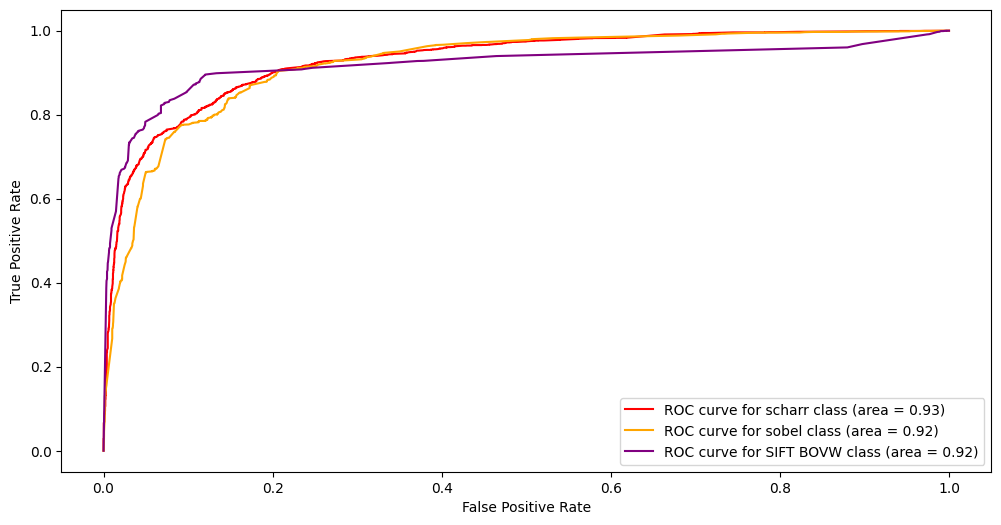

In [105]:
plot_roc(y1, y2, prob_lr, ['scharr', 'sobel', 'SIFT BOVW'])